## TP 5 - Apprentissage non supervisé

Dans ce TP nous allons explorer des techniques d'apprentissage non supervisé. Dans ce contexte on disposera d'une base de données dont les instances $\mathbf{x}_i\in\mathbb{R}^d$ et l'on cherchera à affecter chaque instance à un groupe $y_i=f(\mathbf{x}_i)$ tel que $y_i\in[1,\cdots,k]$. Contrairement à l'apprentissage **supervisé**, on ne dispose pas de labels de référence associés aux instances de la base d'apprentissage, et l'apprentissage est par conséquent **non supervisé**. L'apprentissage non supervisé est plus communément appelé *clustering* car il consiste à découvrir des clusters (des groupes) dans les données brutes.

Nous allons explorer les trois méthodes vues en cours : la Classification Hiérarchique Ascendante (CHA), les k-moyennes, et DBSCAN.

Importez les librairies de base dont nous aurons besoin, comme aux TPs précédents:

In [1]:
# import des outils mathématiques
import numpy as np

# import des outils d'affichage
import matplotlib.pyplot as plt

# import des outils de machine learning
import sklearn as skl
import sklearn.datasets as data


De l'importance de la Normalisation
----

En apprentissage supervisé, la détection des regroupements repose sur la notion de distance dans l'espace. Il est donc important de bien faire attention à la normalisation des dimensions des vecteurs d'entrée afin d'éviter qu'un attribut ne domine tous les autres.
Ceci est illustré par le résultat de la cellule suivante.

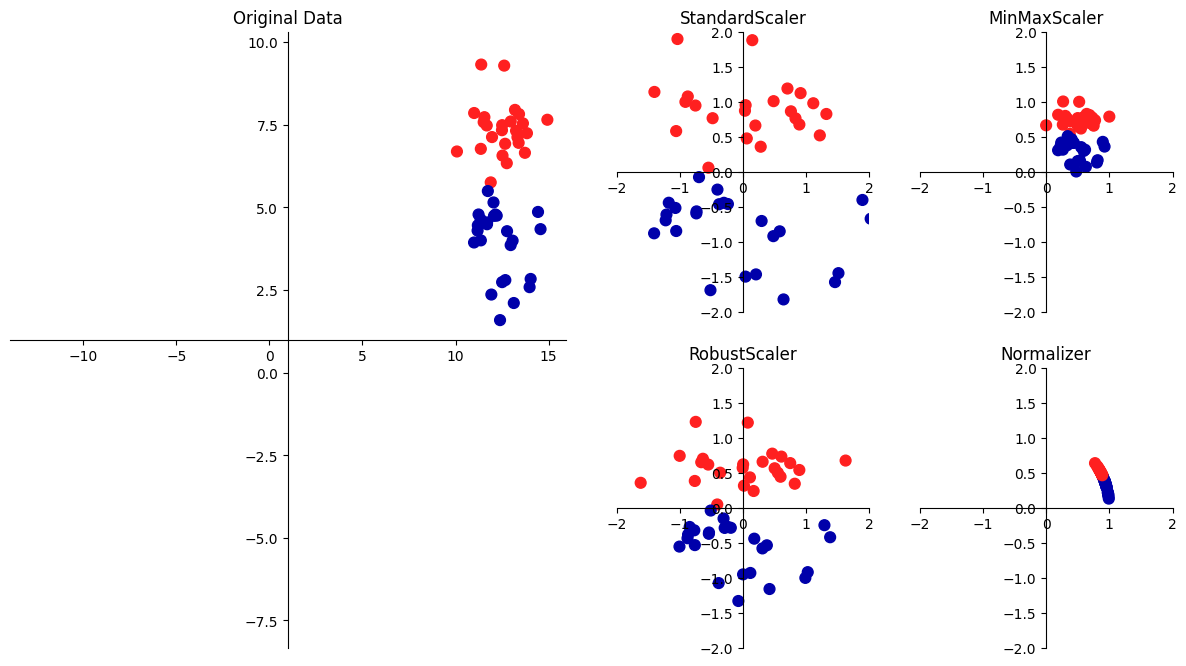

In [2]:
import mglearn
mglearn.plots.plot_scaling()

Dans cet exemple les données originales sont regroupées entre 10 et 15 sur l'axe des $x$ alors qu'elles sont étalées sur l'axe des $y$. Si l'on mesure des distances directement sur ces données, l'axe des $y$ donnera de plus grandes différences et il dominera l'axe des $x$ dans le calcul de distance entre deux vecteurs $\mathbf{x}_i\in\mathbb{R}^2$. On peut contrer cela en utilisant une mise à l'échelle. Nous en avons déjà utilisé dans les TPs précédents dans les pipeline. Il en existe différents issus de `from sklearn.preprocessing`. Nous allons les étudier. Importez le dataset breast cancer avec `data.load_breast_cancer` de scikit-learn, récupérez données et labels dans les vecteurs $x$ et $y$, puis découpez les en train/test. 

In [3]:
from sklearn.model_selection import train_test_split

# Load breast cancer dataset
bc = data.load_breast_cancer()
x = bc.data
y = bc.target

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Pour appliquer un scaler sur les données, on l'importe, on l'applique sur les données de train avec `fit` afin de fixer les paramètres de normalisation et on appplique ceux-ci pour normaliser les données de test avec `transform`. Nous l'avons déjà fait dans les TPs précédents. Appliquez un `StandardScaler` et un `MinMaxScaler` aux données cancer. Pour chaque méthode de normalisation vous afficherez les valeurs minimales et maximales du dataset (utilisez `min` et `max` en précisant `axis=0` en paramètre). Que constatez vous sur la normalisation des attributs ?

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# StandardScaler
std_scaler = StandardScaler()
x_train_std = std_scaler.fit_transform(x_train)
x_test_std = std_scaler.transform(x_test)

# MinMaxScaler
minmax_scaler = MinMaxScaler()
x_train_minmax = minmax_scaler.fit_transform(x_train)
x_test_minmax = minmax_scaler.transform(x_test)

# Print min and max values for each scaling method
print("StandardScaler:")
print("Min values:", x_train_std.min(axis=0)[:5], "...")
print("Max values:", x_train_std.max(axis=0)[:5], "...")
print("\nMinMaxScaler:")
print("Min values:", x_train_minmax.min(axis=0)[:5], "...")
print("Max values:", x_train_minmax.max(axis=0)[:5], "...")

StandardScaler:
Min values: [-1.81958292 -2.22350028 -1.80949689 -1.36503621 -3.10001135] ...
Max values: [3.9616794  4.71567382 3.97681115 5.20831246 4.8646424 ] ...

MinMaxScaler:
Min values: [0. 0. 0. 0. 0.] ...
Max values: [1. 1. 1. 1. 1.] ...


Il est très important de bien apppliquer la même normalisation aux ensembles de test et d'apprentissage afin que les données soient dans la même échelle. Pour bien comprendre cela, réalisez ceci: créez un dataset synthétique avec `make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)`. On ne se servira pas des labels générés pour ce dataset. Écrivez une fonction `plot_data(x)`pour l'afficher.

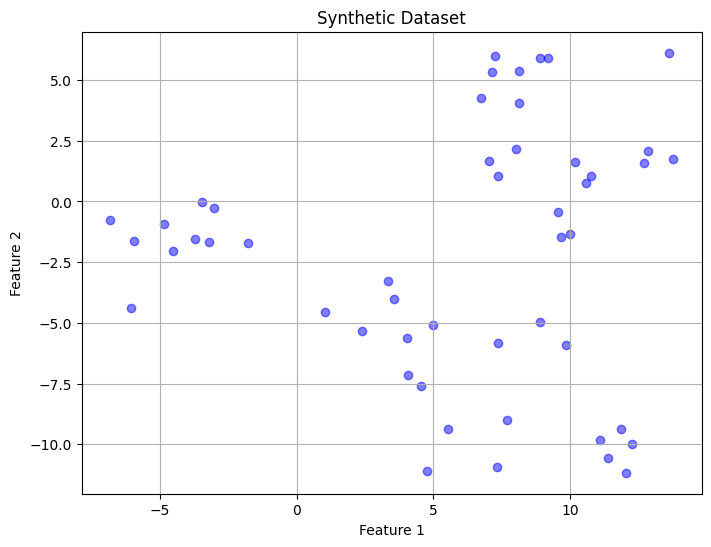

In [5]:
from sklearn.datasets import make_blobs

# Create synthetic dataset
x, _ = make_blobs(n_samples=50, centers=5, random_state=4, cluster_std=2)

def plot_data(x):
    plt.figure(figsize=(8, 6))
    plt.scatter(x[:, 0], x[:, 1], c='blue', alpha=0.5)
    plt.title('Synthetic Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid(True)
    plt.show()

# Plot the data
plot_data(x)

Découpez les données en train/test, puis appliquez une normalisation MinMaxScaler() séparément sur les données train/test (`fit` appliqué sur chacun **séparément**). Affichez les données non normalisées, normalisées séparément, comparez avec l'application d'un fit sur le train puis d'un transform sur le test. Que constatez-vous ?

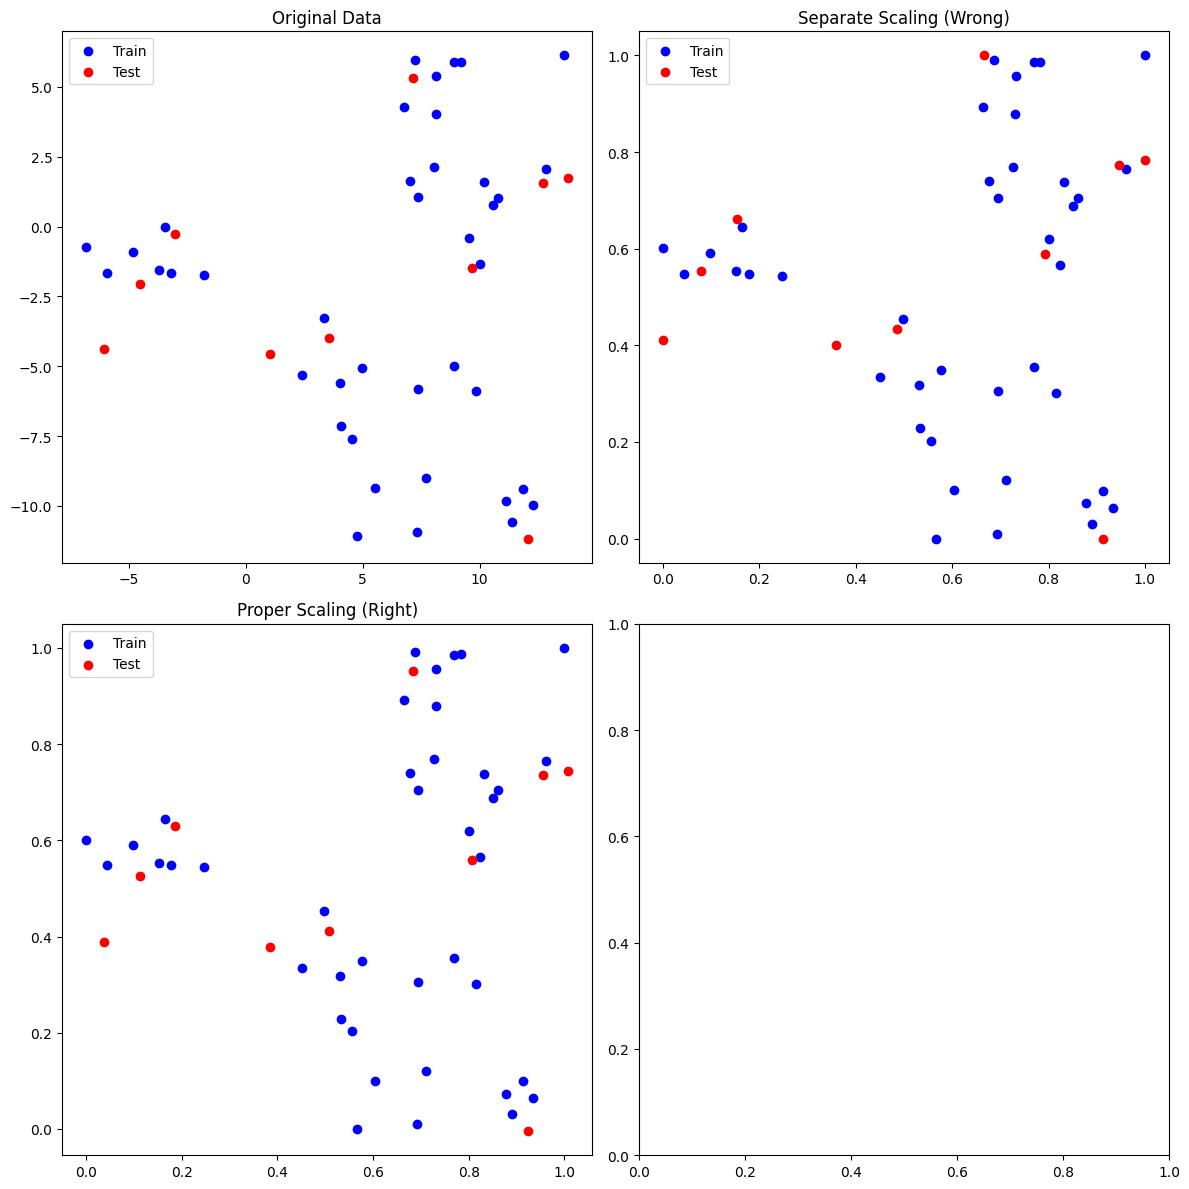

In [6]:
# Split the data
x_train_split, x_test_split = train_test_split(x, test_size=0.2, random_state=42)

# Create MinMaxScalers
scaler_separate_train = MinMaxScaler()
scaler_separate_test = MinMaxScaler()
scaler_proper = MinMaxScaler()

# 1. Separate scaling (wrong way)
x_train_wrong = scaler_separate_train.fit_transform(x_train_split)
x_test_wrong = scaler_separate_test.fit_transform(x_test_split)

# 2. Proper scaling (right way)
x_train_proper = scaler_proper.fit_transform(x_train_split)
x_test_proper = scaler_proper.transform(x_test_split)

# Create plots to compare
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original data
axes[0,0].scatter(x_train_split[:, 0], x_train_split[:, 1], c='blue', label='Train')
axes[0,0].scatter(x_test_split[:, 0], x_test_split[:, 1], c='red', label='Test')
axes[0,0].set_title('Original Data')
axes[0,0].legend()

# Separate scaling (wrong way)
axes[0,1].scatter(x_train_wrong[:, 0], x_train_wrong[:, 1], c='blue', label='Train')
axes[0,1].scatter(x_test_wrong[:, 0], x_test_wrong[:, 1], c='red', label='Test')
axes[0,1].set_title('Separate Scaling (Wrong)')
axes[0,1].legend()

# Proper scaling (right way)
axes[1,0].scatter(x_train_proper[:, 0], x_train_proper[:, 1], c='blue', label='Train')
axes[1,0].scatter(x_test_proper[:, 0], x_test_proper[:, 1], c='red', label='Test')
axes[1,0].set_title('Proper Scaling (Right)')
axes[1,0].legend()

plt.tight_layout()
plt.show()

Maintenant que l'on connait l'importance de la normalisation des données, on y fera particulièrement attention avant l'apprentissage.

La Classification Hiérarchique Ascendante (CHA)
-----

Pour comprendre le principe de la CHA, exécutez la cellule suivante qui en illustre le principe.

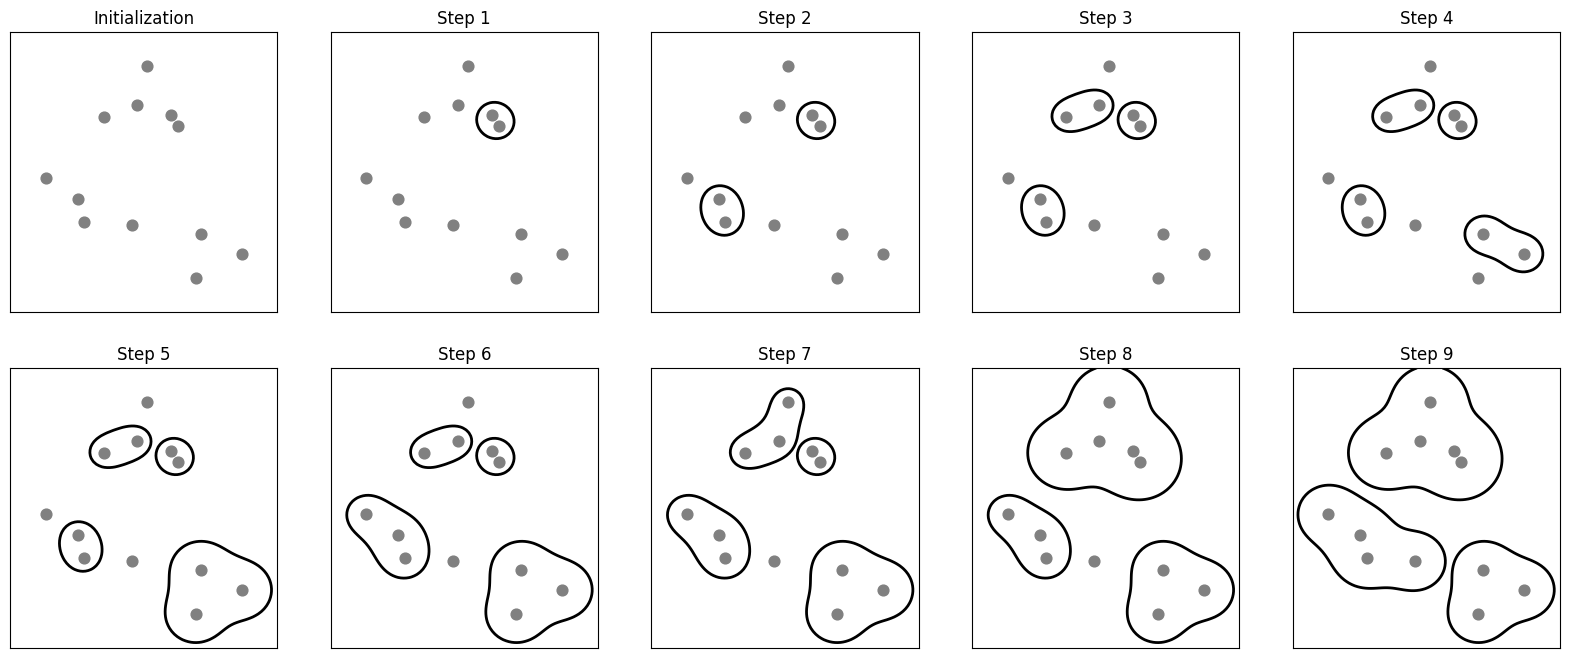

In [7]:
mglearn.plots.plot_agglomerative_algorithm()

La CHA peut se réaliser avec la classe `AgglomerativeClustering` de `sklearn.cluster` (documentation à https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering). Importez là. Créez un dataset synthétique (avec `make_blobs`) de 3 centres avec 300 instances et `cluster_std=0.60`. Normalisez le dataset puis appliquez la CHA avec `fit_predict` pour 3 clusters (la fonction renvoie les labels). Affichez le résultat avec la fonction `mglearn.discrete_scatter` qui prend trois paramètres : les données selon la première dimension, les donnéees selon la seconde dimension et les prédictions. Essayez en variant le nombre de clusters entre 2 et 5. Constatez les différences. On peut laisser la CHA décider du nombre de classes "optimal" sans le préciser en paramètres, constatez quel nombre de clusters a été retenu.

On constate que choisir le nombre de clusters automatiquemen est difficile. Pour cela on peut s'aider d'une représentation sous forme d'un arbre de la CHA. Celui-ci est nommé un dendogramme et montre les agglomérations successives effectuées par la CHA. Le code de la cellule suivante permet de l'afficher. La fonction plot_dendrogram prend en paramètre un CHA après application de `fit`.

In [ ]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model):    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix)

On crée alors la CHA en précisant que l'on ne veut pas choisir un nombre de clusters (`distance_threshold=0, n_clusters=None`) puis on l'applique avec `fit`. Affichez le dendogramme Cela vous aide-t-il à choisir le nombre de clusters ?

Les k-moyennes
----

Les k-moyennes sont un algorithme populaire et efficace pour le clustering. La cellule suivante illustre son principe. On tire des centres de clusters au hasard. Itérativement, jusqu'à ce que les centres ne bougent plus, on assigne chaque instance au cluster le plus proche et on recalcule les coordonnées des centres à partir des instances affectées à chaque cluster.

In [ ]:
mglearn.plots.plot_kmeans_algorithm()
mglearn.plots.plot_kmeans_boundaries()

Essayez les k-moyennes (la classe `Kmeans` de `sklearn.cluster` avec 3 classes et `n_init=1`) sur les données précédemment générées (après normalisation), il faut faire `fit` et récupérer les labels prédits avec l'attribut `.labels_`. Affichez ensuite le résultat  ainsi que les centres (disponibles dans l'attribut `.cluster_centers_`). Ajoutez l'argument `markers` à la fonction `mglearn.discrete_scatter` pour changer le symbole des points affichés. Utilisez `markers='.'` pour les données et `markers='X'` pour les centres. Testez en variant le nombre de clusters de 2 à 5. Changez `n_init=1` en `n_init='auto'`, et refaites le test, constatez vous une différence ?

Pour choisir le nombre de classes, on peut s'aider de l'inertie intra cluster (attribut `.inertia`). Faites varier le nombre de clusters de 1 à 12, appliquez les km-moyennes avec `n_init='auto'` pour ces différents nombres de clusters et stockez l'inertie dans un tableau. Affichez là ensuite. Quel semble être le meilleur nombre de clusters ?

DBSCAN
------

DBSCAN est un algorithme de clustering par la recherche de point connectés en étudiant leur voisinage. Les clusters doivent avoir un nombre de point minimum dans un voisinage de rayon epsilon. La cellule suivante en donne une illustration.

In [ ]:
mglearn.plots.plot_dbscan()

Appliquez DBSCAN sur les données générées normalisées, en jouant sur les paramètres `eps` et `min_samples`. Il faut faire `fit` et récupérer les labels prédits avec l'attribut `.labels_`. Affichez le résultat.

Comparaison des trois algorithmes
-----

Pour comparer les trois algorithmes, nous allons reprendre (comme dans le TP4) un dataset de type twomoons. Générez un tel dataset avec les paramètres suivants : `n_samples=200, noise=0.05, random_state=0`. Normalisez le. Affichez le (avec les classes, cela nous aidera à évaluer les algorithmes de clustering bien qu'ils n'aient pas accès à cette information). Testez les trois algorithmes CHA, kmeans et DBSCAN, avec 2 clusters à détecter. Affichez leurs résultats et accuracy. Attention parfois les clusters n'ont pas la même numérotation, essayez d'y pallier. Quel est le meilleur algorithme ?

Programmons les k-moyennes !
-------

Les k-moyennes sont un algorithme dont le principe est simple et il est est donc "relativement" facile à programmer. Le code ci-dessous vous donne une base de départ, à vous de la compléter. Testez votre code sur les two moons pour vérifier que vous obtenez bien quelque chose de similaire au kmeans de scikit-learn.

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def kmeans_clusters(x, n_clusters):
    # 1. Choisir aléatoirement les centres des clusters, utilisez np.random.random
    
    end=False
    
    while not(end):
        # 2a. Assigner les labels selon les distances minimum, utilisez pairwise_distances_argmin
        
        
        # 2b. Trouver les nouveaux centres en moyennant les points des clusters et les stocker dans un tableau numpy nommé new_centers
        # On peut avoir la moyenne des points d'un cluster i avec [x[labels == i].mean(0)]
        
        # 2c. Vérifier si on a convergé (les nouveaux centres sont identiques aux précédents ?), utilisez np.all

        
        centers = new_centers
    
    return centers, labels

centers, labels = kmeans_clusters(x_scaled, 2)
